In [61]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV


# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [62]:
data = pd.read_csv("datasets/taxi.csv")
data.info()
display(data.describe())
display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [63]:
# Convertimos datatime a formato correcto y marcamos como índice la columna datetime
data["datetime"]=data["datetime"].astype("datetime64[ns]")
data.set_index("datetime",inplace=True)
data.sort_index(inplace=True)

In [64]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<Axes: title={'center': 'Taxi demand'}, xlabel='datetime'>

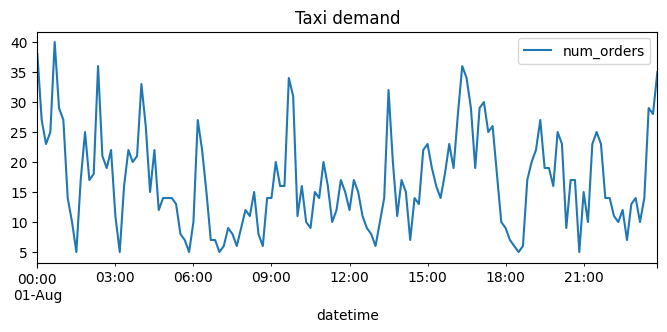

In [65]:
# Graficamos la serie temporal de un día
data["2018-08-01":"2018-08-01"].plot(figsize=(8,3), title="Taxi demand")


<Axes: title={'center': 'Taxi demand resampled'}, xlabel='datetime'>

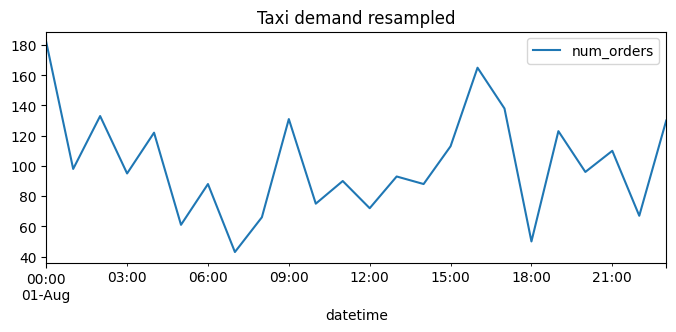

In [66]:
# Realizamos remuestreo de la serie temporal a una frecuencia horaria
data = data.resample("h").sum()
# Graficamos la serie temporal de un día
data["2018-08-01":"2018-08-01"].plot(figsize=(8,3), title="Taxi demand resampled")

__OBSERVACIONES:__
- Se realizo un remuestreo por hora para entender y analizar de manera correcta los pedidos por hora
- No existen valores duplicados ni ausentes

## Análisis

<Axes: title={'center': 'Taxi demand resampled'}, xlabel='datetime'>

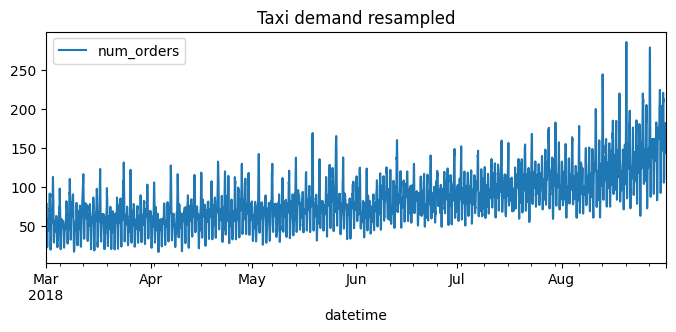

In [67]:
# Veamos el comportamiento promedio en un lapso de 5 horas
data.rolling(5).mean().plot(figsize=(8,3), title="Taxi demand resampled")

<Axes: xlabel='datetime'>

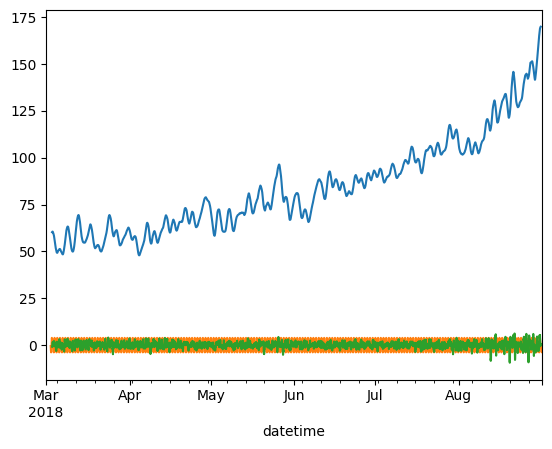

In [68]:
# Ampliaremos la ventana a una semana debido a que tenemos bastantes datos y veremos la tendencia, estacionalidad y residuo
decomposed = seasonal_decompose(data)

H_per_week=int((24*7)/4)


decomposed.trend.rolling(H_per_week).mean().plot()
decomposed.seasonal.rolling(H_per_week).mean().plot()
decomposed.resid.rolling(H_per_week).mean().plot()


<Axes: xlabel='datetime'>

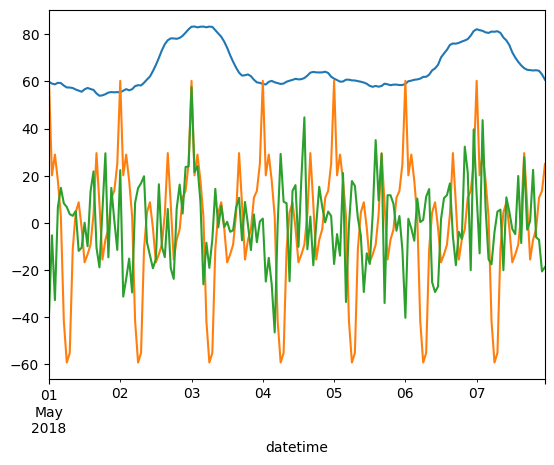

In [69]:
# Ahora analicemos de una semana más detallada la estacionalidad
decomposed.trend["2018-05-01":"2018-05-07"].plot()
decomposed.seasonal["2018-05-01":"2018-05-07"].plot()
decomposed.resid["2018-05-01":"2018-05-07"].plot()

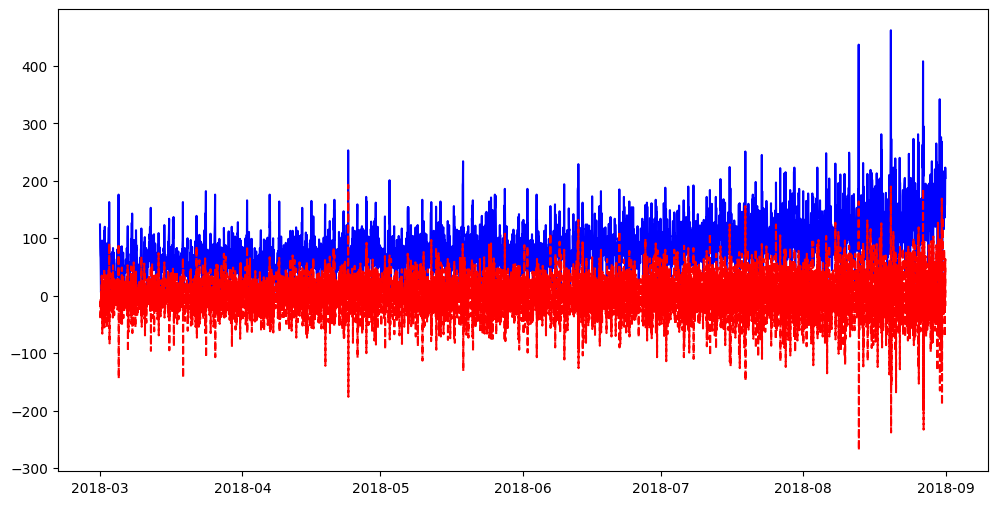

In [70]:
cambio = data['num_orders'] - data['num_orders'].shift(1)
# Grafico combinado
plt.figure(figsize=(12, 6))
plt.plot(data.index,data['num_orders'], label ='Pedidos', color='blue')
plt.plot(data.index,cambio, label ='Cambio', color='red',linestyle='--')

__OBSERVACIONES:__
- A lo largo de los meses, los pedidos estan aumentando en volumen promedio especialmente apartir del mes de Junio.
- Se ve clara la estacionalidad entre las diferentes horas teniendo valles y picos al observar mas a detalle por 1 semana.


In [71]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Formación

Iniciareos creando carácterisiticas para poder entrenar el modelo con nuestro target de número de ordenes.

In [72]:
# Vamos a definir carácteristicas para el modelo
def make_features(df, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for i in range(1, max_lag + 1):
        data[f'lag_{i}'] = data['num_orders'].shift(i)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

    decomposed = seasonal_decompose(data['num_orders'], model='additive', period=rolling_mean_size)
    
    data['trend'] = decomposed.trend
    data['seasonal'] = decomposed.seasonal
    data.dropna(inplace=True)

Aplicaremos esta función a nuestros datos, eligimos arbitrariamente ```max_lag=5``` y ```rolling_mean_size=5```, esto para capturar la información de las ultimas horas previas a la predicción y buscamos la correlaión entre nuestras variables. Esto se aplica antes de la separación de sets, para mantener los sets de validación y prueba completos.

In [73]:
make_features(data,5,5)
data.corr()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,trend,seasonal
num_orders,1.000000,NaN,0.509359,0.162444,-0.020339,0.622860,0.464459,0.320267,0.247188,0.228140,0.493961,0.832274,0.009945
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.509359,NaN,1.000000,0.000418,-0.012325,0.509668,0.509794,0.509914,0.509423,0.508969,0.668245,0.667727,0.000196
day,0.162444,NaN,0.000418,1.000000,-0.014263,0.163160,0.164040,0.164066,0.163859,0.162678,0.214499,0.211218,0.001204
dayofweek,-0.020339,NaN,-0.012325,-0.014263,1.000000,-0.027925,-0.029956,-0.029379,-0.029168,-0.029454,-0.038263,-0.021368,0.000150
lag_1,0.622860,NaN,0.509668,0.163160,-0.027925,1.000000,0.622879,0.464395,0.319658,0.246428,0.696120,0.794448,-0.006099
lag_2,0.464459,NaN,0.509794,0.164040,-0.029956,0.622879,1.000000,0.622827,0.463946,0.319025,0.794553,0.696279,0.001995
lag_3,0.320267,NaN,0.509914,0.164066,-0.029379,0.464395,0.622827,1.000000,0.622749,0.463717,0.832499,0.494573,0.001824
lag_4,0.247188,NaN,0.509423,0.163859,-0.029168,0.319658,0.463946,0.622749,1.000000,0.622070,0.794220,0.393019,-0.005619
lag_5,0.228140,NaN,0.508969,0.162678,-0.029454,0.246428,0.319025,0.463717,0.622070,1.000000,0.695139,0.346917,0.009810


- Notamos que existe una correlacion fuerte entre el ``num_orders`` y ``lag_1``

Ahora separaremos en conjunto de entrenamiento validación y prueba, esto con una proporcion:
- entrenamiento (train): 72%
- validación (valid): 18%
- prueba (test): 10%

In [74]:
train, test = train_test_split(data, shuffle=False, test_size=0.1) #train sirve de forma auxiliar
train, valid = train_test_split(train, shuffle=False, test_size=0.2) #train sirve de forma auxiliar

In [75]:
# Creamos objetivo y variables predictoras
train_features = train.drop(columns=['num_orders'])
train_target = train['num_orders']
valid_features = valid.drop(columns=['num_orders'])
valid_target = valid['num_orders']
test_features = test.drop(columns=['num_orders'])
test_target = test['num_orders']

In [76]:
train_features

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,trend,seasonal
datetime,,,,,,,,,,,,
2018-03-01 07:00:00,2018,3,1,3,12.0,6.0,43.0,66.0,71.0,39.6,27.2,-0.321542
2018-03-01 08:00:00,2018,3,1,3,15.0,12.0,6.0,43.0,66.0,28.4,38.8,0.302268
2018-03-01 09:00:00,2018,3,1,3,34.0,15.0,12.0,6.0,43.0,22.0,55.6,-0.647907
2018-03-01 10:00:00,2018,3,1,3,69.0,34.0,15.0,12.0,6.0,27.2,58.6,0.539607
2018-03-01 11:00:00,2018,3,1,3,64.0,69.0,34.0,15.0,12.0,38.8,58.2,0.127575
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-11 06:00:00,2018,7,11,2,77.0,153.0,117.0,152.0,84.0,116.6,83.0,-0.647907
2018-07-11 07:00:00,2018,7,11,2,81.0,77.0,153.0,117.0,152.0,116.0,73.2,0.539607
2018-07-11 08:00:00,2018,7,11,2,28.0,81.0,77.0,153.0,117.0,91.2,78.0,0.127575


In [77]:
#Escalaremos las caracteristicas en preparación para algunos modelos, escalando primero para los datos de entrenamiento y usando dicha escala para los datos de validación y prueba, evitando el data leakage.
scaler = StandardScaler()
scaler.fit(train_features)
train_features_scaled=scaler.transform(train_features)
valid_features_scaled=scaler.transform(valid_features)
test_features_scaled=scaler.transform(test_features)

### __EENTRENAMIENTO MODELOS__
- Regresión lineal
- Arbol aleatorio de regresión
- Bosque aleatorio de regresión
- Potenciación de gradiente (CatBoost)

### __Regresion Lineal__

In [78]:
model=LinearRegression()
model.fit(train_features_scaled,train_target)
train_predictions=model.predict(train_features_scaled)
valid_predictions=model.predict(valid_features_scaled)
test_predictions=model.predict(test_features_scaled)

train_error_lineal=root_mean_squared_error(train_predictions,train_target)
valid_error_lineal=root_mean_squared_error(valid_predictions,valid_target)
test_error_lineal = root_mean_squared_error(test_predictions,test_target)

print("RECM para el conjunto de entrenamiento:",root_mean_squared_error(train_predictions,train_target)) 
print("RECM para el conjunto de validacion:",valid_error_lineal) 
print("RECM para el conjunto de prueba:",test_error_lineal) 

RECM para el conjunto de entrenamiento: 20.19295241902554
RECM para el conjunto de validacion: 27.87057953082111
RECM para el conjunto de prueba: 35.712324045163676


### __Arbol Aleatorio de Regresion__

In [79]:
model = DecisionTreeRegressor(random_state=12345)
param_grid = {
    'max_depth': [1, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(train_features, train_target)
best_model = grid_search.best_estimator_
train_predictions = best_model.predict(train_features)
valid_predictions = best_model.predict(valid_features)

train_error_tree=root_mean_squared_error(train_predictions,train_target)
valid_error_tree=root_mean_squared_error(valid_predictions, valid_target)
test_error_tree = root_mean_squared_error( best_model.predict(test_features),test_target)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("RECM para el conjunto de entrenamiento:", root_mean_squared_error(train_predictions, train_target)) 
print("RECM para el conjunto de validacion:", valid_error_tree)
print("RECM para el conjunto de prueba:", test_error_tree)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 6}
RECM para el conjunto de entrenamiento: 19.547728964642392
RECM para el conjunto de validacion: 32.564236642240544
RECM para el conjunto de prueba: 49.78992391264726


### __Bosque Aleatorio de Regresión__

In [80]:
model = RandomForestRegressor(random_state=12345)

param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [5, 10, 20, 30],  
    'min_samples_leaf': [1, 4, 8],  
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(train_features, train_target)

best_model = grid_search.best_estimator_

train_predictions = best_model.predict(train_features)
valid_predictions = best_model.predict(valid_features)

train_error_forest=root_mean_squared_error(train_predictions,train_target)
valid_error_forest=root_mean_squared_error(valid_predictions, valid_target)
test_error_forest = root_mean_squared_error( best_model.predict(test_features),test_target)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("RECM para el conjunto de entrenamiento:", root_mean_squared_error(train_predictions, train_target)) 
print("RECM para el conjunto de validacion:", valid_error_forest)
print("RECM para el conjunto de prueba:", test_error_forest)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 8, 'n_estimators': 300}
RECM para el conjunto de entrenamiento: 15.180238638322264
RECM para el conjunto de validacion: 30.622057919360607
RECM para el conjunto de prueba: 47.26163240182782


### __Potenciación de Gradiente con CatBoost__

Aunque todas las columnas son númericas debemos considerar variables catégoricas las cuales seran el mes, año y dia, pues no deben tener preferencia una sobre otra, aunque si orden nominal.

In [83]:
indices_categorias = [1,2,3]
print("Índices de las columnas categóricas:", indices_categorias)

Índices de las columnas categóricas: [1, 2, 3]


In [86]:
best_error = 10000
best_est = 0
best_depth = 0

# Iterar sobre diferentes hiperparámetros
for est in tqdm(range(10, 101, 10)):
    for depth in range(1, 12, 2):
        model = CatBoostRegressor(iterations=est, depth=depth, random_seed=54321, learning_rate=0.1,loss_function='RMSE', verbose=0)

        model.fit(train_features, train_target, cat_features=indices_categorias)
        if error < best_error:
            best_error = error
            best_est = est
            best_depth = depth


train_error_GB = root_mean_squared_error( model.predict(train_features),train_target)
valid_error_GB = root_mean_squared_error( model.predict(valid_features),valid_target)
test_error_GB = root_mean_squared_error( model.predict(test_features),test_target)

print(f"Mejores hiperparámetros: n_estimators: {best_est}, best_depth: {best_depth}")
print("RECM del mejor modelo en el conjunto de entrenamiento:", train_error_GB)
print(f"RECM del mejor modelo en el conjunto de validación: {valid_error_GB}")
print(f"RECM del mejor modelo en el conjunto de prueba: {test_error_GB}")

100%|██████████| 10/10 [01:39<00:00,  9.93s/it]

Mejores hiperparámetros: n_estimators: 10, best_depth: 1
RECM del mejor modelo en el conjunto de entrenamiento: 14.977374966817711
RECM del mejor modelo en el conjunto de validación: 31.557957933914132
RECM del mejor modelo en el conjunto de prueba: 55.59841695736505


## Prueba

In [87]:
modelos = ['Regresión_lineal', 'Árbol_de_regresión', 'Bosque_de_regresión', 'Gradient_Boosting']
train_errors = [train_error_lineal, train_error_tree, train_error_forest, train_error_GB]
valid_errors = [valid_error_lineal, valid_error_tree, valid_error_forest, valid_error_GB]
test_errors = [test_error_lineal, test_error_tree, test_error_forest, test_error_GB]

df = pd.DataFrame({
    "Error de Entrenamiento": train_errors,
    'Error de Validación': valid_errors,
    'Error de Test': test_errors
}, index=modelos)

display(df)

,Error de Entrenamiento,Error de Validación,Error de Test
Regresión_lineal,20.192952,27.870580,35.712324
Árbol_de_regresión,19.547729,32.564237,49.789924
Bosque_de_regresión,15.180239,30.622058,47.261632
Gradient_Boosting,14.977375,31.557958,55.598417


- Se observa como el modelo de regresión lineal es el de mejor desempeño en validación como de prueba, pese a que no sea el mejor ajustado para el mismo modelo de entrenamiento. 

<Axes: title={'center': 'Errores de los Modelos'}, xlabel='Modelos', ylabel='Errores (RECM)'>

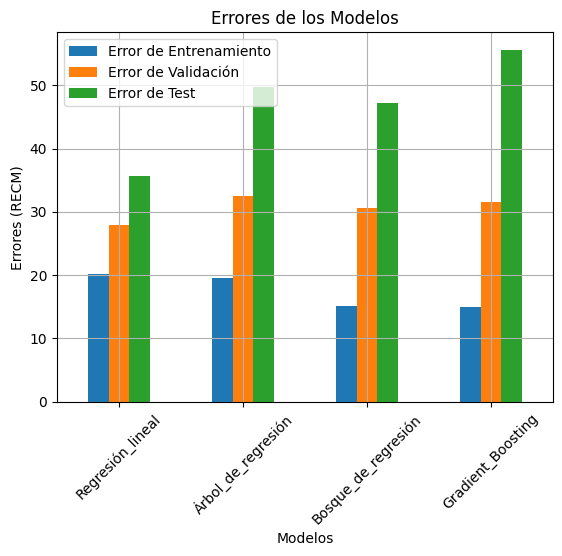

In [88]:
df.plot(kind="bar",rot=45, 
    title="Errores de los Modelos", 
    xlabel="Modelos", 
    ylabel="Errores (RECM)", 
    legend=True,
    grid=True)

## Conclusiones:
- Los modelos de arbol, bosque y potenciación de gradiente se ajustan al set de entrenamiento
- El mejor modelo fue **Regresión lineal** en el set de validación y de prueba, pese a que el ajuste al set de entrenamiento no es tan bueno.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48